# Linear Model for Climate Change Predictions

We use linear regression to predict to predict temperature, diurnal temperature range, precipitation, and 90th percentile precipitation from mean global temperature.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 

In [2]:
# convert from kg/m^2/s to mm/day
KGM2S_TO_MMDAY = 86400

In [3]:
# flatten latitude and longitude to one dimension
def flatten(data):
    return data.stack(dim=['lat','lon'])

### Create Training Data
First, we create the training for our model. We train our model using 4 scenarios: historical, ssp126, ssp370, and ssp585.

In [4]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

In [5]:
# using 2nd ensemble member for historical data since 1st member has missing data
# TODO: try .mean(member)
#ytrain = xr.concat(
#    [xr.open_dataset(f'train_val/outputs_{s}.nc').sel(member=2 if s=='historical' else 1) for s in scenarios]
#    , dim='time')

In [6]:
# average data over ensemble members
ytrain = xr.concat(
    [xr.open_dataset(f'train_val/outputs_{s}.nc').mean('member') for s in scenarios]
    , dim='time')

C:\Users\kaits\anaconda3\Lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [7]:
# convert precipitation data to mm/day
ytrain['pr'] *= KGM2S_TO_MMDAY
ytrain['pr90'] *= KGM2S_TO_MMDAY

In [8]:
# mean temp averaged globally and over training simulations
weights = np.cos(np.deg2rad(ytrain.lat))
global_mean_temp = ytrain['tas'].weighted(weights).mean(['lat', 'lon']).to_numpy().reshape(-1,1)

### Fit Linear Regression Models
Next, we fit 4 linear regression models for each of the output variables.

In [9]:
output_vars = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

In [10]:
# create model for each variable
models = {out: LinearRegression(fit_intercept=False) for out in output_vars}

# fit models
for out in output_vars:
    models[out].fit(global_mean_temp, flatten(ytrain[out]))

### Test Data
We test our models on the test data, ssp245, and compute the RMSE.

In [11]:
# load test data
ytest = xr.open_dataset(f'test/outputs_ssp245.nc')

In [12]:
# process test data
# average over ensemble members
for out in output_vars:
    ytest[out] = ytest[out].mean('member')

# convert precipitation data to mm/day
ytest['pr'] *= KGM2S_TO_MMDAY
ytest['pr90'] *= KGM2S_TO_MMDAY

In [13]:
# get mean temperature averaged globally
test_input = (ytest['tas']
              .weighted(weights)
              .mean(['lat', 'lon'])
              .to_pandas() # convert to pandas to use rolling average
              .rolling(10, min_periods=1)
              .mean()
              .to_numpy() # convert back to numpy to reshape
              .reshape(-1,1))

In [14]:
# get predictions on test data
outputs = {out: models[out].predict(test_input).reshape(86,96,144) for out in output_vars}

### Evaluate Model
We evaluate our model using the NRMSE defined in the ClimateBench paper.

In [15]:
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

In [16]:
def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

In [17]:
def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [18]:
# prints nrmse's
# idk why the diurnal temperature range is like that sos
for out in output_vars:
    nrmse_spatial = get_nrmse_spatial(ytest[out], outputs[out])
    nrmse_global = get_nrmse_global(ytest[out], outputs[out])
    nrmse = get_nrmse(ytest[out], outputs[out])
    
    print(f'The spatial NRMSE for {out} is {nrmse_spatial}.')
    print(f'The global NRMSE for {out} is {nrmse_global}.')
    print(f'The total NRMSE for {out} is {nrmse}. \n')

The spatial NRMSE for tas is 0.0958244067744043.
The global NRMSE for tas is 0.06763518119709791.
The total NRMSE for tas is 0.4340003127598938. 

The spatial NRMSE for diurnal_temperature_range is 2.4032720511960517.
The global NRMSE for diurnal_temperature_range is 0.7922961264831216.
The total NRMSE for diurnal_temperature_range is 6.36475268361166. 

The spatial NRMSE for pr is 2.854230255811057.
The global NRMSE for pr is 0.450128969095086.
The total NRMSE for pr is 5.104875101286487. 

The spatial NRMSE for pr90 is 3.30814665547949.
The global NRMSE for pr90 is 0.5453708235874731.
The total NRMSE for pr90 is 6.035000773416856. 



### Plot true vs. predictions
We plot the true values vs. predictions, and also include their differences.

In [19]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [20]:
# turn output into dataarray to plot
xr_output=xr.Dataset(
    coords={'time': ytest.time.values, 'lat': ytest.lat.values, 'lon': ytest.lon.values})

# assign values to xr_output
for out in output_vars:
    xr_output[out] = (['time', 'lat', 'lon'],  outputs[out])

In [21]:
# variables for plot below
proj = ccrs.PlateCarree()
var_title = ['tas', 'dtr', 'pr', 'pr90']

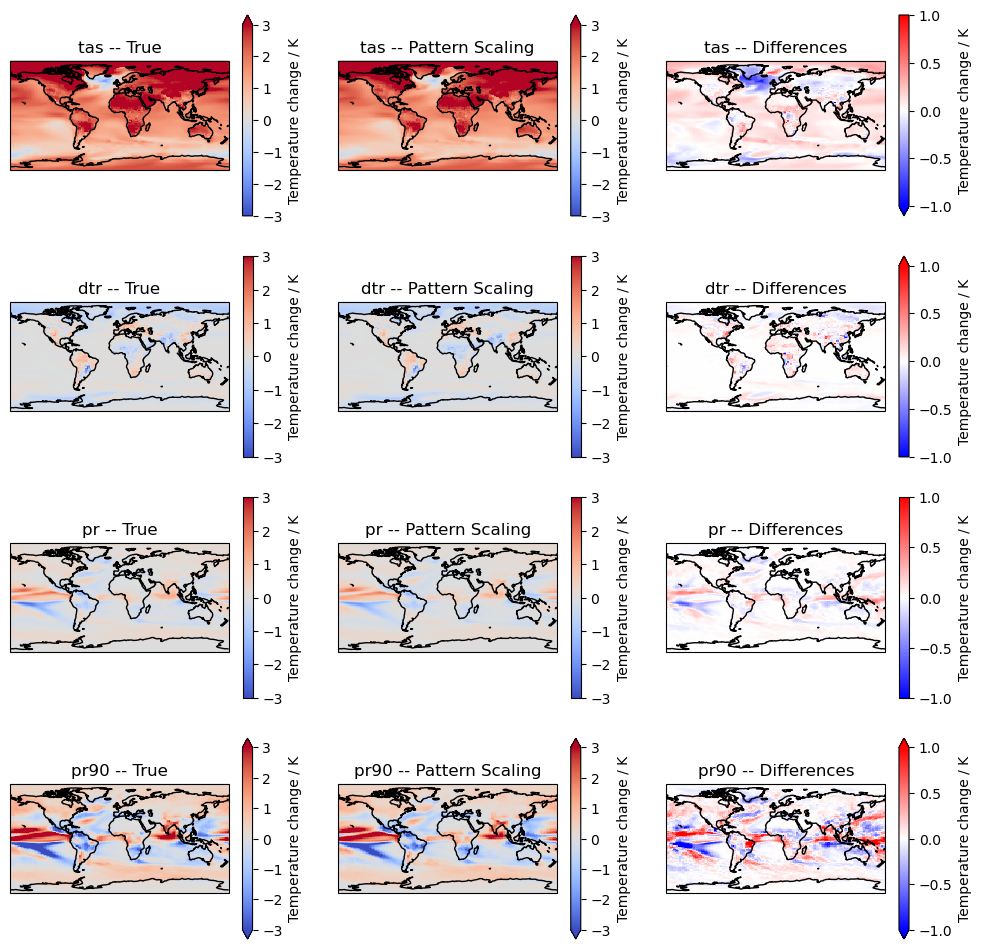

In [22]:
fig = plt.figure(figsize=(12, 12))

for var_num in range(len(output_vars)):
    out = output_vars[var_num]
    for plot_num in range(3):
        if plot_num == 0:
            data = ytest[out]
        elif plot_num == 1:
            data = xr_output[out]
        else:
            data = ytest[out] - xr_output[out]
        
        # plot params
        plot_id = 3 * var_num + plot_num + 1
        colormap = "bwr" if plot_num == 2 else "coolwarm"
        v = 1 if plot_num == 2 else 3
        
        ptitle = var_title[var_num] + ' -- '
        
        if plot_num == 0:
            ptitle += 'True'
        elif plot_num == 1:
            ptitle += 'Pattern Scaling'
        else:
            ptitle += 'Differences'
        
        # plot
        ax = plt.subplot(4, 3, plot_id, projection=proj)
        data.sel(time=slice(2050,None)).mean('time').plot(cmap=colormap, vmax=v,
                                      cbar_kwargs={"label":"Temperature change / K"})
        plt.gca().coastlines()
        plt.setp(plt.gca(), ylabel = 'test1', title=ptitle)   
